# DMI Weather Data

- Yearly reports and data download links are published here: http://polarportal.dk/en/news/news/historical-weather-and-climatedata-for-greenland/
- Data processing scripts and utility functions are in the `scripts/dmi` folder and in `src/grpy/dmi.py`

Data processing pipeline:

1. Pre-processing of raw sub-daily data
2. Compute daily fields
3. Compute monthly fields

## Precipitation Summary

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import grpy as gr

In [2]:
dmi = pd.read_csv('../data/dmi/processed/dmi_monthly.csv', index_col=0)
dmi.head()

,year,month,station id,station name,lat,lon,elevation (m),precip (mm),mean tmax (C),max tmax (C),mean tmin (C),min tmin (C)
0,1982,1,4339.0,Ittoqqortoormiit,70.483333,-21.95,70,6.52,NaN,NaN,NaN,NaN
1,1982,2,4339.0,Ittoqqortoormiit,70.483333,-21.95,70,45.20,NaN,NaN,NaN,NaN
2,1982,3,4339.0,Ittoqqortoormiit,70.483333,-21.95,70,62.41,NaN,NaN,NaN,NaN
3,1982,4,4339.0,Ittoqqortoormiit,70.483333,-21.95,70,4.84,NaN,NaN,NaN,NaN
4,1982,5,4339.0,Ittoqqortoormiit,70.483333,-21.95,70,5.67,NaN,NaN,NaN,NaN


In [3]:
cols = ['station id', 'station name', 'lat', 'lon']
dmi_stns = dmi[cols].groupby('station id').agg(lambda x: x.iloc[0])
dmi_stns.head()

,station name,lat,lon
station id,,,
4200.0,Dundas,76.566667,-68.800000
4201.0,Qaanaaq,77.466667,-69.216667
4202.0,Pituffik,76.533333,-68.750000
4205.0,Mitt. Qaanaaq,77.483333,-69.383333
4210.0,Upernavik,72.783333,-56.166667


In [4]:
cols = ['station id', 'year', 'month', 'precip (mm)']
pcp_monthly = dmi[cols].pivot_table(values='precip (mm)', index=['station id', 'year'], columns='month')
pcp = pcp_monthly.sum(axis=1)
pcp.head(20)

station id  year
4200.0      1961    117.80
            1962     77.67
            1963     46.47
            1964    162.82
            1965    112.68
            1966    172.29
            1967    122.39
            1968    126.63
            1969    127.97
            1970    152.79
            1971    137.24
            1972    122.74
            1973    142.62
            1974     84.40
4202.0      1982     54.80
            1983     94.00
            1984     53.08
            1985    100.25
            1986    170.79
            1987    158.64
dtype: float64

In [5]:
nyrs = pcp.groupby('station id').agg(np.size).astype(int).to_frame(name='nyears')
pcp_bar = pcp.groupby('station id').agg(np.mean)
pcp_bar[pcp_bar == 0] = np.nan
pcp_bar = pcp_bar.to_frame(name='precip')
dmi_df = dmi_stns.join(nyrs, how='outer')
dmi_df = dmi_df.join(pcp_bar, how='outer')
dmi_df.head()

,station name,lat,lon,nyears,precip
station id,,,,,
4200.0,Dundas,76.566667,-68.800000,14.0,121.893571
4201.0,Qaanaaq,77.466667,-69.216667,NaN,NaN
4202.0,Pituffik,76.533333,-68.750000,18.0,122.837778
4205.0,Mitt. Qaanaaq,77.483333,-69.383333,NaN,NaN
4210.0,Upernavik,72.783333,-56.166667,23.0,252.290435


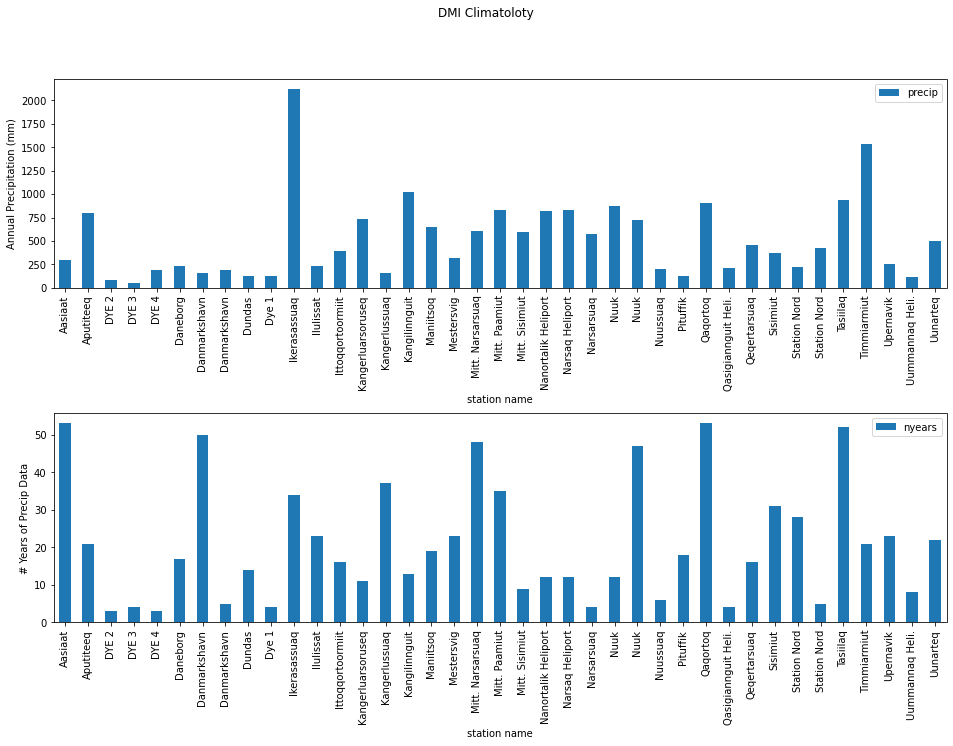

In [6]:
df_plot = dmi_df.sort_values('station name')
df_plot = df_plot[df_plot['precip'].notnull()]

plt.figure(figsize=(16, 10))
plt.suptitle('DMI Climatoloty')
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.6)
df_plot.plot.bar(x='station name', y='precip', ax=plt.gca())
plt.ylabel('Annual Precipitation (mm)')

plt.subplot(2, 1, 2)
df_plot.plot.bar(x='station name', y='nyears', ax=plt.gca())
plt.ylabel('# Years of Precip Data');

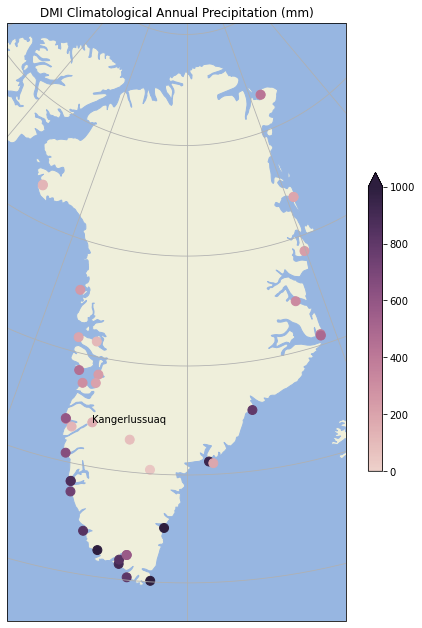

In [7]:
df_plot = dmi_df[dmi_df['precip'].notnull()]
df_kq = dmi_df.loc[4231]
#cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
cmap = sns.cubehelix_palette(8, as_cmap=True)
plt.figure(figsize=(8, 11))

ax, crs = gr.domain_map(greenland_zoom=True)
plt.text(df_kq['lon'], df_kq['lat'], 'Kangerlussuaq', transform=ccrs.Geodetic())
plt.scatter(df_plot['lon'], df_plot['lat'], s=80, c=df_plot['precip'], zorder=2, vmin=0, 
            vmax=1000, cmap=cmap, transform=ccrs.PlateCarree())

plt.colorbar(extend='max', shrink=0.5)
plt.title('DMI Climatological Annual Precipitation (mm)');

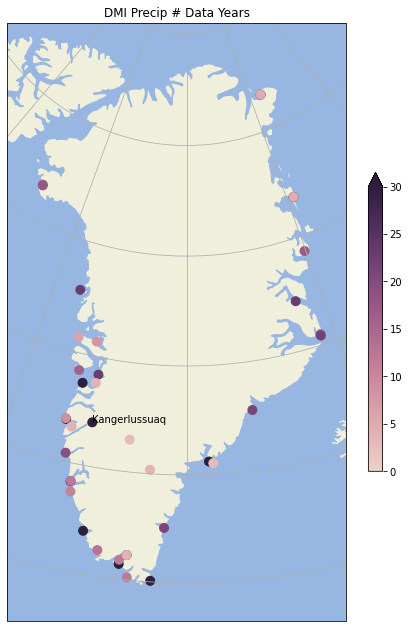

In [8]:
df_plot = dmi_df[dmi_df['precip'].notnull()]
df_kq = dmi_df.loc[4231]
#cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
cmap = sns.cubehelix_palette(8, as_cmap=True)
plt.figure(figsize=(8, 11))

ax, crs = gr.domain_map(greenland_zoom=True)
plt.text(df_kq['lon'], df_kq['lat'], 'Kangerlussuaq', transform=ccrs.Geodetic())
plt.scatter(df_plot['lon'], df_plot['lat'], s=80, c=df_plot['nyears'], zorder=2, vmin=0, 
            vmax=30, cmap=cmap, transform=ccrs.PlateCarree())

plt.colorbar(extend='max', shrink=0.5)
plt.title('DMI Precip # Data Years');

In [9]:
pcp_monthly_clim = pcp_monthly.groupby('station id').mean()
pcp_monthly_clim = pcp_monthly_clim[pcp_monthly_clim[1].notnull()]
#pcp_monthly_clim = pcp_monthly_clim.rename(columns={val : gr.month_str(val) for val in range(1, 13)})
pcp_monthly_clim = (dmi_df.rename(columns={'precip' : 'annual precip'})
                    .join(pcp_monthly_clim, how='right')
                    .sort_values('station name')
                   )
pcp_monthly_clim.head()

,station name,lat,lon,nyears,annual precip,1,2,3,4,5,6,7,8,9,10,11,12
station id,,,,,,,,,,,,,,,,,
4220.0,Aasiaat,68.700000,-52.750000,53.0,302.163208,19.238302,15.921887,16.425283,18.533585,18.086226,25.399811,27.218491,34.793396,34.882075,30.244717,34.655660,26.763774
4350.0,Aputiteeq,67.783333,-32.300000,21.0,794.625238,59.873333,54.660476,71.873333,49.808571,46.177619,74.306667,31.144286,79.500000,107.138571,94.911429,76.808095,48.422857
4465.0,DYE 2,66.483333,-46.283333,3.0,85.566667,2.776667,1.280000,1.620000,6.553333,19.900000,9.016667,12.303333,12.816667,6.920000,9.413333,1.636667,1.330000
4475.0,DYE 3,65.183333,-43.833333,4.0,52.467500,2.125000,2.080000,1.910000,1.732500,2.517500,6.160000,12.415000,9.752500,6.135000,3.365000,1.300000,2.975000
4365.0,DYE 4,65.516667,-37.166667,3.0,185.623333,27.803333,15.606667,20.806667,19.843333,14.286667,6.333333,7.906667,5.036667,9.956667,11.750000,26.373333,19.920000


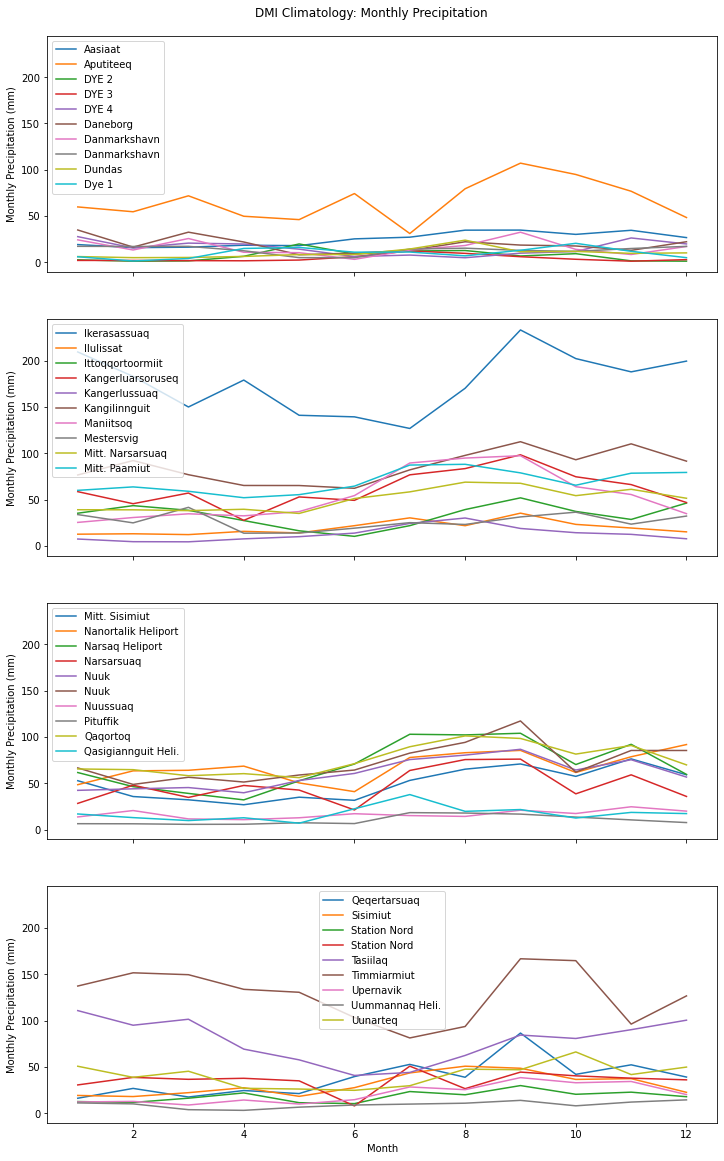

In [10]:
cols = list(range(1, 13))
stns = pcp_monthly_clim.index
stn_lists = [stns[:10], stns[10:20], stns[20:30], stns[30:]]
nr, nc = len(stn_lists), 1
fig, axes = plt.subplots(nr, nc, figsize=(12, 20), sharex=True, sharey=True)
plt.suptitle('DMI Climatology: Monthly Precipitation', y=0.9)
for stn_list, ax in zip(stn_lists, axes):
    plt.sca(ax)
    for stn in stn_list:
        pcp_monthly_clim.loc[stn, cols].plot.line(label=pcp_monthly_clim.loc[stn, 'station name'])
    plt.legend()
    plt.ylabel('Monthly Precipitation (mm)')
    plt.xlabel('Month')